## K-Means Clustering - Mall Customers Dataset
Here we apply Clustering techniques to the **Mall Customers Dataset**, namely in `mall_customers.csv`. This notebook will take us through:
- The exploration of the distribution of clients across two of their features: **Income and Spending Score**
- Finding the **optimal number of clusters** and group individuals, according to their similarities, to inform the Mall Owners of the types of customers that visit their facilities, and ultimately, navigate their strategy in terms of what shops to open, so that they fit the expected client profiles of the mall.

---
#### Dataset Exploration

We want to ideally do the following:
- Exploring the dataset, particularly focusing on features `'Income'` and `'Spending Score'`
- Plotting the distributions of the two features via a **Histogram**
- Plotting a **Scatter Plot**, measuring Income on the x-axis and Spending on the y-axis

In [19]:
# Imports:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [20]:
# Loading the dataset:

df = pd.read_csv(r'./Data/mall_customers.csv')
df.head()

,CustomerID,Gender,Age,Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [21]:
# First, always check for missing data (even if the task doesn't ask for it explicitly)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Income          200 non-null    int64 
 4   Spending_Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


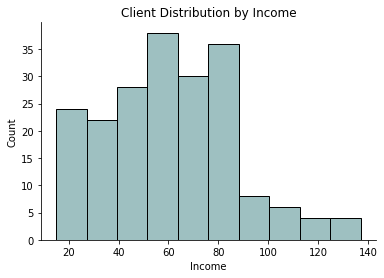

In [22]:
# Visualising the distribution of Income across Clients
g1 = sns.histplot(x = 'Income', data = df, color = '#7EABAD')
g1.set_title('Client Distribution by Income')
sns.despine()
plt.show()

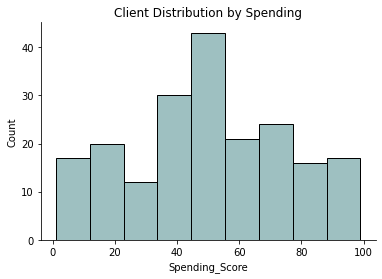

In [23]:
# Visualising the distribution of Spending Score across Clients
g2 = sns.histplot(x = 'Spending_Score', data = df, color = '#7EABAD')
g2.set_title('Client Distribution by Spending')
sns.despine()
plt.show()

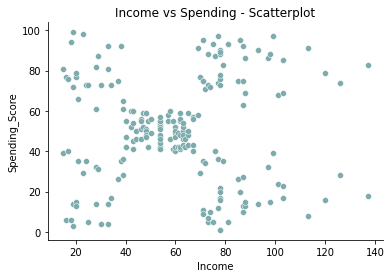

In [24]:
# Visualising a Scatter Plot to see the distribution of clients across both features
g3 = sns.scatterplot(x = 'Income', y= 'Spending_Score', data = df, color ='#7EABAD')
g3.set_title('Income vs Spending - Scatterplot')
sns.despine()
plt.show()

##### Conclusion:
From the scatterplot we can largely spot 5 areas with high concentration of customers. It seems like people in the lower and upper range of their incomes both exhibit two types of behaviours:
- People who spend *a lot* 
- People who spend *little*
People with average income and the only ones who largely spend moderately and don't fall in either of the extreme spending cases.

**Initial proposition - 5 clusters**

---
### Simple K-Means:
Here we give an example of a simple implementation of a K-Means Clustering Algorithm with 2 clusters. We then train a K-Means model and use it to make predictions of the dataset. Finally, we visualise the Scatter Plot of Clients, colouring the points by their cluster belonging:

In [25]:
# Select the data for the Clustering - Income and Spending_Score
X = df[['Income', 'Spending_Score']]


In [26]:
# Initialise the K-Means model with 3 clusters
KMeansModel = KMeans(n_clusters = 2, n_init = 'auto')

# Fit model to the data
KMeansModel.fit(X)
print(f'The cluster centres are positioned at {KMeansModel.cluster_centers_}')

# Cluster the observations by making predictions
y_pred = KMeansModel.predict(X)

# Combine the Income and Spending score data with the cluster assignment in a single dataframe
cluster_df = X.copy()
cluster_df['Cluster'] = y_pred

display(cluster_df)

The cluster centres are positioned at [[50.90789474 43.63157895]
 [91.125      71.        ]]


,Income,Spending_Score,Cluster
0,15,39,0
1,15,81,0
2,16,6,0
3,16,77,0
4,17,40,0
...,...,...,...
195,120,79,1
196,126,28,1
197,126,74,1
198,137,18,1


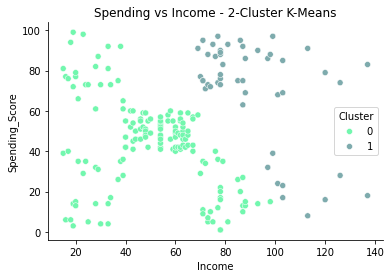

In [27]:
# Visualise the Scatter Plot, adding hue by the cluster belonging
hue_colours = { 0: '#72F7AE', 1:'#7EABAD'}
g = sns.scatterplot(x = 'Income', y= 'Spending_Score', data = cluster_df, hue = 'Cluster', palette=hue_colours)
g.set_title('Spending vs Income - 2-Cluster K-Means')
sns.despine()
plt.show()

---
#### Finding the Optimal Split with the Elbow Method:
We make use of the **Elbow Method** to find the **Optimal Number of Clusters** in the dataset. The general process is to:
- Iterate over a range of clusters - e.g., from 2 to 10
- On each iteration, fit a model and collect the **inertia** of the model 
- Lastly, **plot the line** and try to identify the number of clusters, associated with the elbow of the curve

In [28]:
# Create a container for the Sum of Squared Errors (that is Intra-Cluster Differences)
KMeansModel_SSE_Container = []

In [29]:
# Iterate over a range of clusters - e.g. from 2 to 10
# On each iteration fit a model and append its inertia to the container
for k in range(2,11):
    KMeansModelElbow = KMeans(n_clusters=k, n_init = 'auto')
    KMeansModelElbow.fit(X)
    KMeansModel_SSE_Container.append(KMeansModelElbow.inertia_)


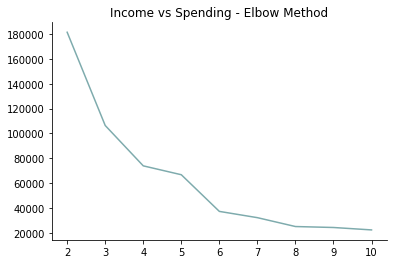

In [30]:
# Plot the number of clusters against the inertia to identify the elbow region
x = np.arange(2,11)
g = sns.lineplot(x=x, y = KMeansModel_SSE_Container, color = '#7EABAD')
g.set_title('Income vs Spending - Elbow Method')
sns.despine()
plt.show()

**Conclusion:** The elbow of the curve associates with 5 clusters

---
#### Finding the Optimal Split with Silhouette Analysis: 
Additionally to the Elbow Method, we can perform a **Silhouette Analysis** to confirm the results. The process is as follows:
- Calculate the silhouette score of a number of models with different number of clusters - e.g. clusters ranging from 2 to 10
- Plot the Silhouette Scores as a line
- The number of clusters that maximises Silhouette Score will be the main candidate 
- Once the optimal number of clusters are found, train a K-Means model, make predictions and calculate the **Silhouette Score** across all samples
- Visualise the Silhouette Score on Sample level to get a more detailed overview of how well each cluster differentiates from the rest

##### Silhouette Score across Models

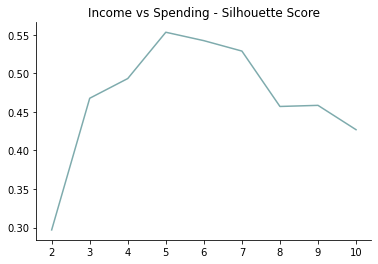

In [31]:
# Create a container for the Silhouette Scores
KMeansModel_Silhouette_Container = []

# Iterate over a range of clusters - e.g. from 2 to 10
# On each iteration fit a model and append its inertia to the container
# Note - for a Silhouette Analysis we require at least 2 clusters
for k in range(2,11):
    KMeansModelSilhouette = KMeans(n_clusters=k, n_init = 'auto')
    KMeansModelSilhouette.fit(X)
    y_pred = KMeansModelSilhouette.predict(X)
    KMeansModel_Silhouette_Container.append(silhouette_score(X,y_pred))

# Plot the number of clusters against the silhouette score to identify optimal k
x = np.arange(2,11)
g = sns.lineplot(x=x, y = KMeansModel_Silhouette_Container, color = '#7EABAD')
g.set_title('Income vs Spending - Silhouette Score')
sns.despine()
plt.show()

##### Silhouette Scores across Samples

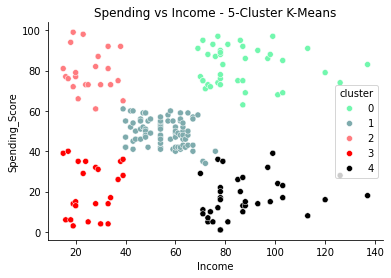

In [32]:
# Select the data for the Clustering
X = df[['Income', 'Spending_Score']]

# Initialise the K-Means model with 5 clusters
KMeansModelSilhouetteSample = KMeans(n_clusters = 5, n_init = 'auto')

# Fit and predict
KMeansModelSilhouetteSample.fit(X)
y_pred = KMeansModelSilhouetteSample.predict(X)

# Store features and predictions in a single dataframe
cluster_df = X.copy()
cluster_df['cluster'] = y_pred

# Plot the Scatter Plot for 5 clusters
hue_colours = {2:'#FF7C80', 0: '#72F7AE', 1:'#7EABAD', 3: 'red', 4:'black'}
g = sns.scatterplot(x = 'Income', y= 'Spending_Score', data = cluster_df, hue = 'cluster', palette=hue_colours)
g.set_title('Spending vs Income - 5-Cluster K-Means')
sns.despine()
plt.show()


In [33]:
# Use predictions to feed into silhouette_samples() function
sample_silhouette_values = silhouette_samples(X,y_pred)

# Concatenate predicted clusters with their silhouette scores per sample
silhouette_df = pd.DataFrame({'cluster':y_pred, 'sil_score':sample_silhouette_values})
silhouette_df.head()

# Sorting observations per cluster and silhouette score
silhouette_df.sort_values(['cluster', 'sil_score'], inplace=True)

# Reset the index and import it, so that the index increases in the same order as cluster and sil_score
silhouette_df.reset_index(inplace=True, drop=True)
silhouette_df.reset_index(inplace=True)

# For the visual, we can also use the model silhouette score (to compare observations against the average)
AvgSilhouetteScore = silhouette_score(X,y_pred)

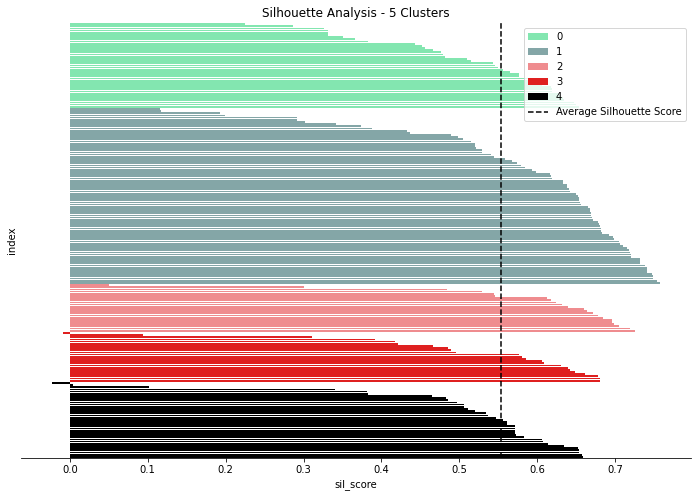

In [34]:
# Visualising the Silhouette Plot on Sample level for all 500 observations

fig, ax = plt.subplots(figsize = (12,8))    # Customise the size of the visual
hue_colours = {2:'#FF7C80', 0: '#72F7AE', 1:'#7EABAD', 3: 'red', 4:'black'}
g = sns.barplot(x = 'sil_score', y = 'index', data = silhouette_df, hue = 'cluster', orient = 'h', ax = ax, palette = hue_colours)
plt.axvline(x=AvgSilhouetteScore, c='black', label = "Average Silhouette Score", linestyle = 'dashed')
g.set_title('Silhouette Analysis - 5 Clusters')
sns.despine(left = True)
ax.set_yticks([])
plt.legend()
plt.show()